# Import Section

In [0]:
# Path
import os

# Data
import numpy as np

# Plot
import matplotlib.pyplot as plt

# Image
from PIL import Image # used in image processing function
from PIL import ImageFilter # used in load_image_pair()

# Tensorflow
import tensorflow as tf

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

# For Tensorflow Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import RandomNormal

# Google Drive
from google.colab import drive


# Colab Function

In [0]:
def gpu_check():
  """
      Check GPU RAM status. Since google colab share gpu resource amount of its
      user, you want to make sure there are enough GPU RAM that are free to use.
      Recommend at least 3000MB free GPU RAM.
  """
  # memory footprint support libraries/code
  !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
  !pip install gputil
  !pip install psutil
  !pip install humanize
  import psutil
  import humanize
  import os
  import GPUtil as GPU
  GPUs = GPU.getGPUs()
  # XXX: only one GPU on Colab and isn’t guaranteed
  gpu = GPUs[0]
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

# Path Functions

In [0]:
def ensure_dir(path_to_dir):
  try:
      os.makedirs(path_to_dir)
  except FileExistsError:
      # directory already exists
      pass

# Config

In [0]:
"""
    config project in this cell.
"""

# Env, where you running this project
# Google colab: 'colab'
env = 'colab'


In [110]:
""" 
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""

# config dictionary
config = {
    'colab':{
        'data_dir':'/content/drive/My Drive/Colab Notebooks/data',
        'checkpoint_dir':'/content/drive/My Drive/Colab Notebooks/checkpoints',
        'log_dir':'/content/drive/My Drive/Colab Notebooks/logs',
    }
}

# setting all variables
data_dir = config[env]['data_dir']
checkpoint_dir = config[env]['checkpoint_dir']
log_dir = config[env]['log_dir']

# mount google drive
if env == 'colab':
  # mount google dirve
  drive.mount('/content/drive')
  # ensure dir exsits
  ensure_dir(checkpoint_dir)
  # check GPU
  gpu_check()
  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Gen RAM Free: 10.8 GB  | Proc size: 4.4 GB
GPU RAM Free: 11101MB | Used: 340MB | Util   3% | Total 11441MB


# Image Processing Function

In [0]:
def array_to_img(x, mode='YCbCr'):
  """
      Convert array to image using YCbCr color
      
      Args:
        x: array of image.
        mode: channel mode, default to 'YCbCr'
              1 (1-bit pixels, black and white, stored with one pixel per byte)
              L (8-bit pixels, black and white)
              P (8-bit pixels, mapped to any other mode using a color palette)
              RGB (3x8-bit pixels, true color)
              RGBA (4x8-bit pixels, true color with transparency mask)
              CMYK (4x8-bit pixels, color separation)
              YCbCr (3x8-bit pixels, color video format)
              Note that this refers to the JPEG, and not the ITU-R BT.2020, standard
              LAB (3x8-bit pixels, the L*a*b color space)
              HSV (3x8-bit pixels, Hue, Saturation, Value color space)
              I (32-bit signed integer pixels)
              F (32-bit floating point pixels)
  """
  return Image.fromarray(x.astype('uint8'), mode=mode)


def bicubic_rescale(image, scale):
  """
      Rescale image using bicubic interpolation.
      
      Args:
        image: image
        scale: use integer for up scaling. use 1/integer for down scaling
  """
  # make sure scale is valid
  if isinstance(scale, (float, int)):
    size = (np.array(image.size) * scale).astype(int)
  '''
  WARNING
  image.resize might lead to image displacement
  https://hackernoon.com/how-tensorflows-tf-image-resize-stole-60-days-of-my-life-aba5eb093f35
  switch to tf.image.resize_bicubic
  '''
  return image.resize(size, resample=Image.BICUBIC)


def modcrop(image, scale):
  """
      To scale down the original image, there must be no remainder while scaling
      operation.
      
      All we want to do in here is to subtract the remainder from height and 
      width of original image size, and cut the original image to the new size.
      
      Args:
        image: original image
        scale: must be int
  """
  if not isinstance(scale, int):
    raise Exception('utils.modcrop: scale must be int')
  size = np.array(image.size)
  size -= size % scale
  return image.crop([0, 0, *size])

# Data Preprocessing

In [0]:
def load_image_pair(path, scale=3, greyscale=False, same_size=False):
  """
      Down scaling a hight resolution image to a low resolution image and
      return both of them.
      
      Args:
        path: image path
        scale: scale of down scaling, must be a int
        greyscale: return only Y channel
  """
  image = load_img(path)
  image = image.convert('YCbCr')
  
  if greyscale:
    Y, Cb, Cr = image.split()
    Y.show()
    image = Y
  
  hr_image = modcrop(image, scale)
  lr_image = bicubic_rescale(hr_image, 1 / scale)
  lr_image = bicubic_rescale(lr_image, scale)
  lr_image = lr_image.filter(ImageFilter.GaussianBlur(radius=2))
  return lr_image, hr_image


def generate_sub_images(image, size, stride):
  """
      Cut image into sub images.
      
      Args:
        image: image
        size: size of sub image
        stride: distance of how much the window shifts by in each of the 
                dimensions
  """
  for i in range(0, image.size[0] - size + 1, stride):
        for j in range(0, image.size[1] - size + 1, stride):
            # yield return a generator, or a list of number
            yield image.crop([i, j, i + size, j + size])
            
            
class Dataset:
  
  def __init__(self):
    self.lr_sub_size = 0
    self.lr_sub_stride = 0
    self.hr_sub_size = 0
    self.hr_sub_stride = 0
    self.lr_array = []
    self.hr_array = []
    
    
  def load_set(self, dataset_name, lr_sub_size, lr_sub_stride, scale, same_size=False, greyscale=False):
    """
        Load all image from a directory and cut them into small sub image.

        Args:
          dataset_name: name of dir of the data set
          lr_sub_size: low resolution sub image size
          lr_sub_stride: stride when crop sub image
          scale: down scale value
          same_size: hr, lr have the same size
          greyscale: return only Y channel
    """
    if not all(isinstance(i, int) for i in [lr_sub_size, lr_sub_stride, scale]):
      raise Exception('utils.load_set: lr_sub_size, stride, scale must be int')
      
    self.lr_sub_size = lr_sub_size
    self.lr_sub_stride = lr_sub_stride
      
    # compute parameters for hight resolution image
    if same_size:
      self.hr_sub_size = lr_sub_size
      self.hr_sub_stride = lr_sub_stride
    else:
      self.hr_sub_size = lr_sub_size * scale
      self.hr_sub_stride = lr_sub_stride * scale
    
    for file_name in os.listdir(os.path.join(data_dir, dataset_name)):
      path = os.path.join(data_dir, dataset_name, file_name)
      lr_image, hr_image = load_image_pair(str(path), scale=scale, greyscale=greyscale, same_size=same_size)
      self.lr_array.append(lr_image)
      self.hr_array.append(hr_image)
      
      
  def show_set(self):
    """
      view the first 3 image of the dataset
    """
    f, axarr = plt.subplots(2, 3, figsize=(18,18))
    
    # Plot images in subplot
    axarr[1,2].imshow(self.hr_array[0])
    axarr[1,1].imshow(self.hr_array[1])
    axarr[1,0].imshow(self.hr_array[2])
    axarr[0,2].imshow(self.lr_array[0])
    axarr[0,1].imshow(self.lr_array[1])
    axarr[0,0].imshow(self.lr_array[2])
    
    # Disable axis
    axarr[1,2].axis("off")
    axarr[1,1].axis("off")
    axarr[1,0].axis("off")
    axarr[0,2].axis("off")
    axarr[0,1].axis("off")
    axarr[0,0].axis("off")
   
    plt.show()
    
  
  def sub_image_set(self):
    """
      return the sub image dataset
    """
    lr_sub_arrays = []
    hr_sub_arrays = []
    
    for lr_image, hr_image in zip(self.lr_array, self.hr_array):
      lr_sub_arrays += [img_to_array(img) for img in generate_sub_images(lr_image, size=self.lr_sub_size, stride=self.lr_sub_stride)]
      hr_sub_arrays += [img_to_array(img) for img in generate_sub_images(hr_image, size=self.hr_sub_size, stride=self.hr_sub_stride)]
    
    # convert list to np.array
    x = np.stack(lr_sub_arrays)
    y = np.stack(hr_sub_arrays)

    return x, y 

  def clear_set(self):
    """
      reset Dataset
    """
    self.lr_array = []
    self.hr_array = []
    
    
# TODO
# normalization?
# Seng: add a layer called BatchNormalization in model
# https://keras.io/layers/normalization/

# Helper Function

In [0]:
def train(
    model,
    model_name,
    train_set,
    val_set,
    epochs=1,
    steps_per_epoch=30,
    validation_steps=3,
    resume=True):
  """
    train function for all model.
    
    
  """
  path_to_weight_file = os.path.join(checkpoint_dir,model_name)

  # define callbacks
  callbacks = [
    # Save checkpoints of model at regular intervals
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_to_weight_file,
        save_best_only=True
    )
  ]
  
  # inherit weights
  if resume:
    model.load_weights(path_to_weight_file)
  
  # Train
  history = model.fit(train_set, epochs=epochs, callbacks=callbacks, steps_per_epoch=steps_per_epoch,
            validation_data=val_set, validation_steps=validation_steps)
  
  # plot metrics
  plot_based_accuracy(history)
  plot_based_loss(history)
  

def test(model, test_set, steps=30, metrics=None):
  # test
  model.evaluate(test_set, steps=steps)

def plot_based_loss(history):
  '''
  Plot training & validation loss values
  history: a dictionary recording training loss values and metrics values at successive epochs
  '''
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  
def plot_based_accuracy(history):
  '''
  Plot training & validation accuracy values
  history: a dictionary recording training loss values and metrics values at successive epochs
  '''
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

# Model

In [0]:
def srcnn(img_size, channel=1, f1=9, n1=64, n2=32, f3=5):
  '''
  img_size: the size of the input image
  channel: the number of channels in the input image
  f1: the size of filter (must be odd #)
  n1: the number of filter apply on layer 1
  n2: the number of filter apply on layer 2
  f3: the size of filter (must be odd #)
  
  
  from: https://arxiv.org/abs/1501.00092
  '''  
  
  if not isinstance(img_size, (int)):
    raise Exception('img_size is not a valid size in srcnn model')
  
  initializer = RandomNormal(mean=0.0, stddev=0.001)
  model = Sequential()
  model.add(Conv2D(filters=n1, kernel_size=f1, padding='same', activation='relu',
                   kernel_initializer=initializer, input_shape=(img_size,img_size,channel)))
  model.add(Conv2D(filters=n2, kernel_size=1, padding='same', activation='relu',
                  kernel_initializer=initializer))
  model.add(Conv2D(filters=channel, kernel_size=f3, padding='same', activation='linear',
                  kernel_initializer=initializer))
  
  # either SGD or Adam
  #optimizer = SGD(lr=0.0003)
  optimizer = Adam(lr=0.0003)
  model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
  
  model.summary()
  
  return model



# Model Training

## Model Config

In [115]:
# size of sub image
size = 32

# strde when crop image
stride = 14

# upscaling factor
scale = 1

# batch size
batch = 32

# size of low resolution and high resolution image is the same?
same_size = True

# greyscale ON or OFF? if ON, img will only contain Y channel
greyscale = True

# whcih training dataset you want to use?
train_dataset_dir = '91-image'

# which validation dataset you want to use?
val_dataset_dir = 'Set5'

# which testing dataset you want to use?
test_dataset_dir = 'Set14'

# which model you want to train or test?
model = srcnn(size, 1, 9, 64, 32, 5)
# set the name of model below
model_name = 'srcnn'

# epochs
epochs = 15000

# steps_per_epoch
steps_per_epoch = 30

# validation_steps
validation_steps = 3

# resume last traning?
resume = False
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        5248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


## Make Data

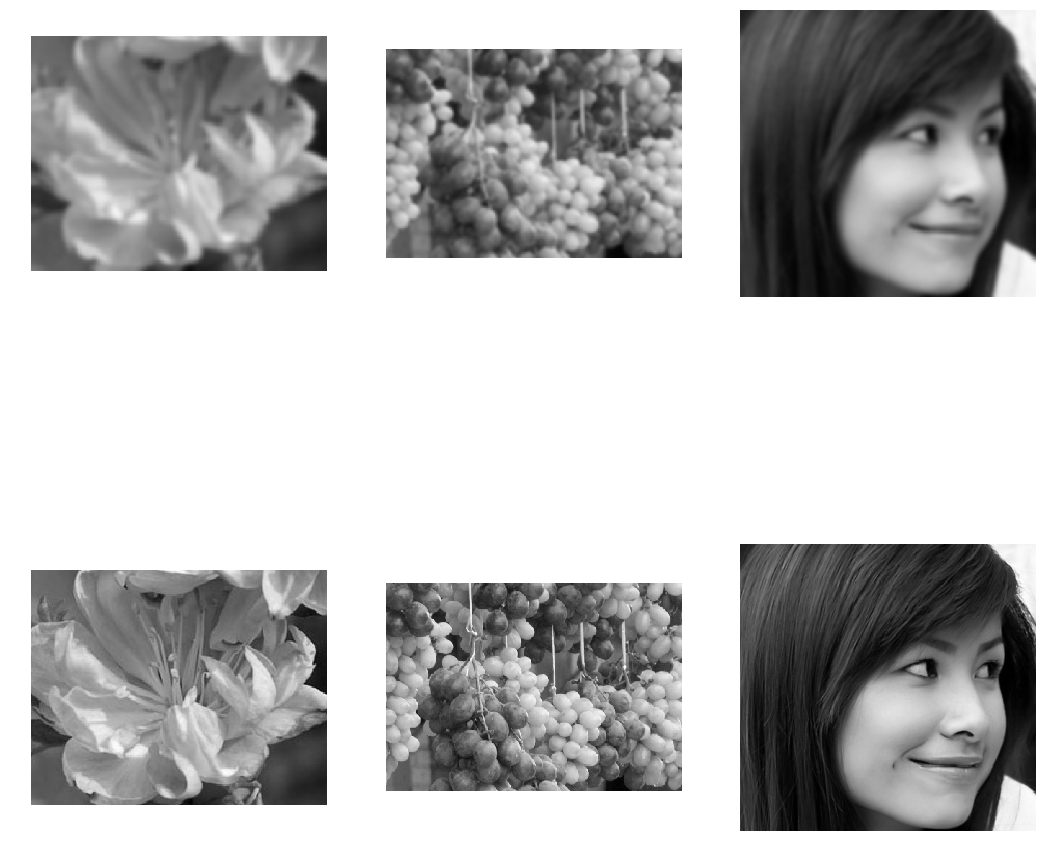

In [116]:
""" 
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
dataset = Dataset()

# load tranning dataset
dataset.load_set(train_dataset_dir, size, stride, scale, same_size, greyscale)
dataset.show_set()
train_lr, train_hr = dataset.sub_image_set()

# make tf.data dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_lr, train_hr))
train_dataset = train_dataset.batch(batch)
train_dataset = train_dataset.repeat()

# load validation dataset
dataset.clear_set()
dataset.load_set(val_dataset_dir, size, stride, scale, same_size, greyscale)
val_lr, val_hr = dataset.sub_image_set()
# make tf.data dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_lr, val_hr))
val_dataset = val_dataset.batch(batch//10)
val_dataset = val_dataset.repeat()

In [117]:
""" 
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
train(model, model_name, train_dataset, val_dataset, epochs, steps_per_epoch, validation_steps, resume)

Epoch 1/15000
30/30 [==============================] - 1s 27ms/step - loss: 13148.3033 - mean_squared_error: 13148.3057 - val_loss: 6857.6252 - val_mean_squared_error: 6857.6250
Epoch 2/15000
30/30 [==============================] - 0s 11ms/step - loss: 2321.7479 - mean_squared_error: 2321.7478 - val_loss: 603.0640 - val_mean_squared_error: 603.0640
Epoch 3/15000
30/30 [==============================] - 0s 9ms/step - loss: 1298.2395 - mean_squared_error: 1298.2394 - val_loss: 2104.7092 - val_mean_squared_error: 2104.7092
Epoch 4/15000
30/30 [==============================] - 0s 9ms/step - loss: 1536.5723 - mean_squared_error: 1536.5724 - val_loss: 1974.0499 - val_mean_squared_error: 1974.0499
Epoch 5/15000
30/30 [==============================] - 0s 10ms/step - loss: 1537.9228 - mean_squared_error: 1537.9226 - val_loss: 210.8320 - val_mean_squared_error: 210.8320
Epoch 6/15000
30/30 [==============================] - 0s 9ms/step - loss: 1369.2485 - mean_squared_error: 1369.2484 - val_l

KeyboardInterrupt: ignored